In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from math import *

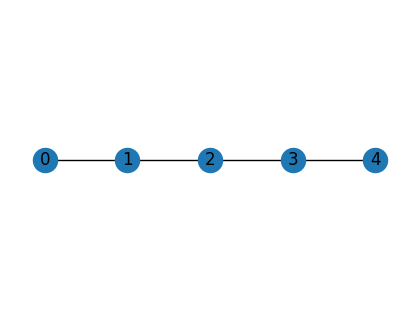

In [21]:
# network graph
N = 5# number of nodes
node_list = np.arange(N)
G = nx.Graph()
G.add_nodes_from(node_list)
p = 40
adj_mat = np.zeros((N,N))
for n in range(N-1):
    adj_mat[n,n+1] = p
adj_mat += adj_mat.T

pos = dict()
for node in range(N):
    pos[node] = (p*node,0)
    
G = nx.from_numpy_array(adj_mat)
plt.figure(figsize=(4,3))
nx.draw(G, pos = pos,  with_labels=True)
plt.show()


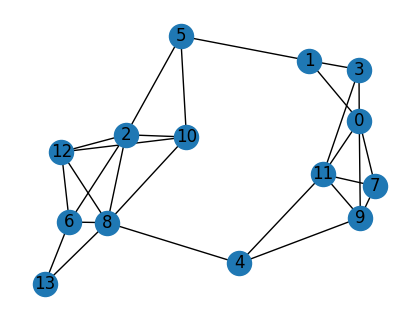

In [38]:
# random network graph of N nodes
N = 14# number of nodes
node_list = np.arange(N)

# nodes are distributed uniformly within an L0xL0 square
L0 = 100 # square dim in km
length = L0
width = L0
dmax = 0.4*L0 # cut off for elementary links
random.seed(20)#33)
pos = dict()
for node in range(N):
    pos[node] = (random.random()*length,random.random()*width)
    
G = nx.random_geometric_graph(N, dmax, dim=2, pos=pos, p=2)

weights = dict()
transmission = dict()
for e in G.edges():
    dist = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
    weights[e] = dist
    transmission[e] = 10**(-0.2*dist/10)
    
nx.set_edge_attributes(G, values = weights, name = 'weight')
nx.set_edge_attributes(G, values = transmission, name = 'trans')

plt.figure(figsize=(4,3))
nx.draw(G,pos,with_labels=True)
plt.show()

In [4]:
# functions to be used for calculations, plotting, etc.

def ent_rate_memory_exact(p_list,W):
    # calculates the e2e rate of a path with a list of success prob
    # and W memories
    N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return np.sum(np.arange(1,W+1)*P[:,N-1])

def ent_rate_memory_gaussian(p_list,W, Wmax = 100):
    N = len(p_list)
    Q = np.zeros((Wmax,N))
    P = np.zeros((Wmax,N))
    for k in range(N):
        p_k = p_list[k]
        for i in range(Wmax):
            Q[i,k] = gaussian_dist(i+1,W*p_k,sqrt(W*p_k*(1-p_k))) 
            
    P[:,0] = Q[:,0]
    for k in range(1,N):
        for i in range(Wmax):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1]) 
    return np.sum(np.arange(1,Wmax+1)*P[:,-1])

def binomial_dist(i,W,p_k):
    return comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

def gaussian_dist(x,μ,σ):
    return 1/(σ*sqrt(2*pi))*np.exp(-(x-μ)**2/σ**2/2)

def gk_gaussian_dist(x,μ,σ):
    return 1/(σ*sqrt(2*pi))*gk.exp(-(x-μ)**2/σ**2/2)


def ent_calc_x(user_pair,x_opt,w_opt,Wmax = 100):
    num_nodes = len(R_list)
    Q = np.zeros((Wmax,2+num_nodes**2))
    P = np.zeros(Wmax)
    t = t_list[user_pair]
         
    for i in range(Wmax):
        for n1 in (list(R_list)+ [t]):
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
            Q[i,0] += x_opt[user_pair,s,n1]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 
            P[i] += x_opt[user_pair,s,n1]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 

    for i1, n1 in enumerate(R_list):
        for i2, n2 in enumerate(R_list):
            if n2 != n1:
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                for i in range(Wmax):
                    Q[i,i1*num_nodes+i2+1] = gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 

    counter = 0 
    for i1, n1 in enumerate(R_list):
        for i2, n2 in enumerate(R_list):
            for i in range(Wmax):
                P[i] = P[i]* (np.sum(Q[i:,counter+1])**x_opt[user_pair,n1,n2]) + x_opt[user_pair,n1,n2]*Q[i,counter+1]* np.sum(P[i+1:]) 
            counter += 1

    for n1 in R_list:
        p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
        for i in range(Wmax):
            Q[i,-1] += x_opt[user_pair,n1,t]*gaussian_dist(i+1,w_opt*p_k,sqrt(w_opt*p_k*(1-p_k))) 
    for i in range(Wmax):
        P[i] = P[i]* np.sum(Q[i:,-1])**np.sum( x_opt[user_pair,R_list,t]) + np.sum( x_opt[user_pair,R_list,t])* Q[i,-1]* np.sum(P[i+1:]) 
    return np.sum(np.arange(1,Wmax+1)*P), P

def plot_output(x_opt,y_opt):
    plt.figure(figsize=(4,3))
    for i,y_val in enumerate(y_opt):
        if i not in np.concatenate((s_list,t_list)):
            if y_val == 1:
                plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
                plt.text(pos[i][0],pos[i][1],"%d" % i)
            else:
                plt.plot(pos[i][0],pos[i][1],"bo")
                plt.text(pos[i][0],pos[i][1],"%d" % i)

    for e in G.edges():
        plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = "black", linewidth=0.1)
    colors = ["violet","orange","gray"]
    for user_pair in range(C):
        s = s_list[user_pair]
        plt.plot(pos[s][0],pos[s][1],"s", color = colors[user_pair])
        plt.text(pos[s][0],pos[s][1],"%d" % s)
        t = t_list[user_pair]
        plt.plot(pos[t][0],pos[t][1],"s", color = colors[user_pair])
        plt.text(pos[t][0],pos[t][1],"%d" % t)

        edges = np.argwhere(x_opt[user_pair,:,:]>0)
        path_output = []
        for e in edges:
            if G.has_edge(e[0],e[1]):
                plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
                path_output.append(list(e))
            else:
                path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
                path_output.append(path)
                for i in range(len(path)-1):
                    e1 = path[i]
                    e2 = path[i+1]
                    plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)

        print((s_list[user_pair],t_list[user_pair]),":",path_output)
#     plt.xlim([0,L0])
#     plt.xlim([0,L0])
    plt.show()
    


## Gekko implementation of NILP
multiuser, w memory per (s,d) is a decision variable

In [23]:
Nmax = 10
# Lmax = 41 # maximum link length
D0 = 2
D = D0*np.ones(N)
s_list = [0] # source
t_list = [N-1] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))

from gekko import GEKKO
m = GEKKO()

w = m.Array(m.Var,C, value=D0 ,integer=True,lb=1)
x = m.Array(m.Var,(C,N,N),integer=True,lb=0,ub=1)
y = m.Array(m.Var,N, value=0 ,integer=True,lb=0,ub=1)

# for r in R_list:
#     m.Equation( y[r]==0 )

# for r in np.concatenate((s_list,t_list)):
#     m.Equation( y[r]==0 )

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    sum2_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += w[user_pair]*(x[user_pair,n1,t] + np.sum(x[user_pair,n1,n_list]))
        sum2_const += w[user_pair]*(x[user_pair,s,n1] + np.sum(x[user_pair,n_list,n1]))
    m.Equation( sum1_const <= D[n1]*y[n1] )
    m.Equation( sum2_const <= D[n1]*y[n1] )

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
#     m.Equation( nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair,s,t] <= Lmax)    
    m.Equation( x[user_pair,s,t] == 0)    
    
    number = np.sum(x[user_pair,s,R_list]+ x[user_pair,R_list,t])
    for n1 in R_list:
#         m.Equation( x[user_pair,n1,n1] == 0)    
#         m.Equation( x[user_pair,n1,s] == 0)    
#         m.Equation( x[user_pair,t,n1] == 0)    
#         m.Equation( nx.shortest_path_length(G, source=s, target=n1, weight="weight")*x[user_pair,s,n1] <= Lmax)
#         m.Equation( nx.shortest_path_length(G, source=n1, target=t, weight="weight")*x[user_pair,n1,t] <= Lmax)        

#         for n2 in R_list:
#             if n2 != n1:
#                 m.Equation( nx.shortest_path_length(G, source=n1, target=n2, weight="weight")*x[user_pair,n1,n2] <= Lmax)
                
        n_list = np.array(list(set(R_list)-{n1}))
        m.Equation( x[user_pair,n1,t] - x[user_pair,s,n1] + np.sum(x[user_pair,n1,n_list] - x[user_pair,n_list,n1]) == 0)
        number += np.sum(x[user_pair,n1,n_list])

    m.Equation( number <= Nmax)
    m.Equation( x[user_pair,s,t] + np.sum(x[user_pair,s,R_list]) == 1)
    m.Equation( x[user_pair,s,t] + np.sum(x[user_pair,R_list,t]) == 1)
             
gk = GEKKO()

num_nodes = len(R_list)
Wmax = 10
q_size = 2+num_nodes**2
Q = np.array([[0]*q_size]*Wmax).tolist()
P = np.array([[0]*q_size]*Wmax).tolist()
rate = [None]*C
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]

    for i in range(Wmax):
        q_sum = 0
        for n1 in (list(R_list)+ [t]):
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=s, target=n1, weight="weight")/10) 
            q_sum += x[user_pair,s,n1]*gk_gaussian_dist(i+1,w[user_pair]*p_k,gk.sqrt(w[user_pair]*p_k*(1-p_k))) 
        Q[i][0] = m.Intermediate( q_sum )
        P[i][0] = m.Intermediate( q_sum )

    for i1, n1 in enumerate(R_list):
        for i2, n2 in enumerate(R_list):
            if n2 != n1:
                p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) 
                for i in range(Wmax):
                    Q[i][i1*num_nodes+i2+1]  = m.Intermediate( gk_gaussian_dist(i+1,w[user_pair]*p_k,gk.sqrt(w[user_pair]*p_k*(1-p_k))) )

    counter = 0 
    for i1, n1 in enumerate(R_list):
        for i2, n2 in enumerate(R_list):
            k = i1*num_nodes+i2+1
            for i in range(Wmax):
                P[i][counter+1] = m.Intermediate( P[i][counter]* (np.sum(np.array(Q)[i:,counter+1])**x[user_pair,n1,n2]) + x[user_pair,n1,n2]* Q[i][counter+1] * np.sum(np.array(P)[i+1:,counter]) ) 
            counter += 1

    for i in range(Wmax):
        q_sum = 0
        for n1 in R_list:
            p_k= 10**(-0.2*nx.shortest_path_length(G, source=n1, target=t, weight="weight")/10) 
            q_sum  += x[user_pair,n1,t]*gk_gaussian_dist(i+1,w[user_pair]*p_k,gk.sqrt(w[user_pair]*p_k*(1-p_k))) 
        Q[i][-1] = m.Intermediate( q_sum )

    for i in range(Wmax):
        P[i][-1] = m.Intermediate( P[i][counter]* np.sum(np.array(Q)[i:,-1])**np.sum(x[user_pair,R_list,t]) + np.sum(x[user_pair,R_list,t])*Q[i][-1]* np.sum(np.array(P)[i+1:,counter]) )
    rate[user_pair] = m.Intermediate(m.log(np.sum(np.arange(1,Wmax+1)*np.array(P)[:,-1]) ))

# m.solver_options = ['minlp_gap_tol 0.01']#'minlp_gap_tol 0.5', 'minlp_integer_tol 0.06']
# # optional solver settings with APOPT
# m.solver_options = ['minlp_maximum_iterations 500', \
#                     # minlp iterations with integer solution
#                     'minlp_max_iter_with_int_sol 20', \
#                     # treat minlp as nlp
#                     'minlp_as_nlp 1', \
#                     # nlp sub-problem max iterations
#                     'nlp_maximum_iterations 50', \
#                     # 1 = depth first, 2 = breadth first
#                     'minlp_branch_method 2', \
#                     # maximum deviation from whole number
#                     'minlp_integer_tol 0.1', \
#                     # covergence tolerance
#                     'minlp_gap_tol 0.0000001']

# At most ymax number of repeaters
# ymax = 2
# m.Equation( np.sum(y[R_list]) >= ymax )
m.Maximize(np.sum(rate))#+np.sum(y[R_list])) #
m.options.SOLVER = 1
m.solve()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in range(N):
    y_opt[i] = y[i][0]
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] = x[user_pair,i,j][0]

apm 67.169.68.205_gk_model15 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           38
   Intermediates:          191
   Connections  :            0
   Equations    :          205
   Residuals    :           14
 
 Number of state variables:             38
 Number of total equations: -           13
 Number of slack variables: -            7
 ---------------------------------------
 Degrees of freedom       :             18
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.02 NLPi:    2 Dpth:    0 Lvs:    0 Obj:  6.17E+01 Gap:  0.00E+00
 Successful solution
 
 -------------

(0, 4) : [[0, 1], [1, 2, 3, 4]]


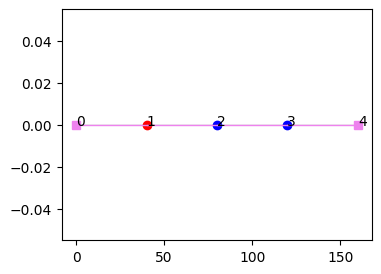

optimal memory, e2e rate for  (0, 4)  : ( 2.0 , -61.669465962 )
exact val e2e rate: -6.066359737603415
-------------------
agg e2e rate post process: -61.66946596197941
obj fn. (agg e2e rate) : -61.669465962
which nodes are repeaters:  [0. 1. 0. 0. 0.]


In [24]:
plot_output(x_opt,y_opt)       
e2e_rate_opt = np.zeros(C)
agg_rate = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
    agg_rate += rate[user_pair][0] 
    print("optimal memory, e2e rate for ", (s,t)," : (", w[user_pair][0],",", rate[user_pair][0],")")

    w_opt = w[user_pair][0]
    s = s_list[user_pair]
    edges = np.argwhere(x_opt[user_pair,:,:]>0)
    path_prob = []
    path_dist = []
    path_output = []
    for e in edges:
        path_prob.append(10**(-0.2*nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight")/10) )
        path_dist.append( nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight") )
        if G.has_edge(e[0],e[1]):
            path_output.append(list(e))
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
#     print("gaussian matrix e2e:", ent_rate_memory_gaussian(path_prob,w_opt,Wmax=10))
    print("exact val e2e rate:", np.log(ent_rate_memory_exact(path_prob,int(w_opt))))
    print("-------------------")
    e2e_rate_opt[user_pair], p_x = ent_calc_x(user_pair,x_opt,w_opt,Wmax=10)
#     print("gaussian x-based:", e2e_rate_opt[user_pair])

# Sanity check: these two quantities have to be equal:
print("agg e2e rate post process:", np.sum(np.log(e2e_rate_opt)))
print("obj fn. (agg e2e rate) :", agg_rate)
print("which nodes are repeaters: ", y_opt)


In [14]:
p01 = 10**(-0.2*40/10)
p02 = 10**(-0.2*80/10)
r2 = ent_rate_memory_gaussian([p01,p01,p01],2, Wmax = 10)
r1 = ent_rate_memory_gaussian([p01,p02],2, Wmax = 10)
print(np.log(r2),np.log(r1))

-3.3626696658173696 -9.740735393883668
